In [130]:
# Firstly, some necessary imports

# Jupyter notebook related
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Built-in modules
import pickle
import sys
import os
import datetime
import itertools
from aenum import MultiValueEnum

# Basics of Python data handling and visualization
import numpy as np
np.random.seed(42)
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap, BoundaryNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Polygon
from tqdm.auto import tqdm

# Machine learning
import lightgbm as lgb
import joblib
from sklearn import metrics
from sklearn import preprocessing

# Imports from eo-learn and sentinelhub-py
from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, OverwritePermission, \
    LoadTask, SaveTask, EOExecutor, ExtractBandsTask, MergeFeatureTask
from eolearn.io import SentinelHubInputTask, ExportToTiff
from eolearn.mask import AddMultiCloudMaskTask, AddValidDataMaskTask
from eolearn.geometry import VectorToRaster, PointSamplingTask, ErosionTask
from eolearn.features import LinearInterpolation, SimpleFilterTask, NormalizedDifferenceIndexTask
from sentinelhub import UtmZoneSplitter, BBox, CRS, DataCollection

In [208]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as plt_polygon

from mpl_toolkits.basemap import Basemap  

Dimension of the area is 691819564723 m2


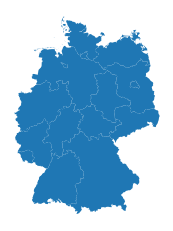

In [555]:
INPUT_FILE = './german.geojson'

# Load geojson file
country = gpd.read_file(INPUT_FILE)
country_crs = country.to_crs("EPSG:32633")

# Plot country
country_crs.plot()
plt.axis('off');

# Print size 
german_area = 0
for state in country_crs.geometry.values:
    state_area = (state.bounds[2] - state.bounds[0]) * (state.bounds[3] - state.bounds[1])
    german_area += state_area
print('Dimension of the area is {0:.0f} m2'.format(german_area))

In [557]:
country_crs.crs

<Projected CRS: EPSG:32633>
Name: WGS 84 / UTM zone 33N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 12°E and 18°E, northern hemisphere between equator and 84°N, onshore and offshore. Austria. Bosnia and Herzegovina. Cameroon. Central African Republic. Chad. Congo. Croatia. Czechia. Democratic Republic of the Congo (Zaire). Gabon. Germany. Hungary. Italy. Libya. Malta. Niger. Nigeria. Norway. Poland. San Marino. Slovakia. Slovenia. Svalbard. Sweden. Vatican City State.
- bounds: (12.0, 0.0, 18.0, 84.0)
Coordinate Operation:
- name: UTM zone 33N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Dimension of the area is 344272 x 366681 m2


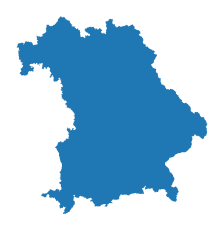

In [558]:
# Get the bayern's shape in polygon format
bayern = country[country.name=='Bayern']
bayern_shape = bayern.geometry.values[-1]
bayern_crs = country_crs[country_crs.name=='Bayern']
bayern_crs_shape = bayern_crs.geometry.values[-1]

# Plot bayern state
bayern.plot()
plt.axis('off');
# Print size
print('Dimension of the area is {0:.0f} x {1:.0f} m2'.format(bayern_crs_shape.bounds[2] - bayern_crs_shape.bounds[0],
                                                             bayern_crs_shape.bounds[3] - bayern_crs_shape.bounds[1]))

In [367]:
bayern_crs['buffer_geo'] = bayern_crs.geometry.buffer(distance=5)
print(bayern_crs.geometry)
print(bayern_crs.buffer_geo)

1    POLYGON ((10.13386 50.55000, 10.13980 50.54252...
Name: geometry, dtype: geometry
1    POLYGON ((12.36516 42.51222, 11.81582 42.42046...
Name: buffer_geo, dtype: geometry


### Splite with BBoxSplitter


In [293]:
bbox_splitter = BBoxSplitter([bayern_crs_shape], (20,20))
print('Area bounding box: {}\n'.format(bbox_splitter.get_area_bbox().__repr__()))
print('Each bounding box also has some info how it was created.\nExample:\n'
      'bbox: {}\ninfo: {}\n'.format(bbox_list[0].__repr__(), info_list[0]))

TypeError: __init__() missing 1 required positional argument: 'split_shape'

### Splite with UtmZoneSplitter

In [560]:
bbox_splitter = UtmZoneSplitter([bayern_crs_shape], bayern_crs.crs, 5000)

bbox_list = np.array(bbox_splitter.get_bbox_list())
info_list = np.array(bbox_splitter.get_info_list())

# Prepare info of selected EOPatches
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list]
idxs = [info['index'] for info in info_list]
idxs_x = [info['index_x'] for info in info_list]
idxs_y = [info['index_y'] for info in info_list]

gdf = gpd.GeoDataFrame({'index': idxs, 'index_x': idxs_x, 'index_y': idxs_y}, 
                           crs=bayern_crs.crs, 
                           geometry=geometry)



index  index_x  index_y  \
0         0        0       61   
1         1        1       57   
2         2        1       58   
3         3        1       59   
4         4        1       60   
...     ...      ...      ...   
3109   3109       28       26   
3110   3110       28       27   
3111   3111       28       28   
3112   3112       28       29   
3113   3113       28       30   

                                               geometry  
0     POLYGON ((495000.000 5540000.000, 495000.000 5...  
1     POLYGON ((500000.000 5520000.000, 500000.000 5...  
2     POLYGON ((500000.000 5525000.000, 500000.000 5...  
3     POLYGON ((500000.000 5530000.000, 500000.000 5...  
4     POLYGON ((500000.000 5535000.000, 500000.000 5...  
...                                                 ...  
3109  POLYGON ((410000.000 5385000.000, 410000.000 5...  
3110  POLYGON ((410000.000 5390000.000, 410000.000 5...  
3111  POLYGON ((410000.000 5395000.000, 410000.000 5...  
3112  POLYGON ((410000.000 5400000.000, 410000.000 5...  
3113  POLYGON ((410000.000 5405000.000, 410000.000 5...  

[3114 rows x 4 columns]

In [542]:
from typing import AbstractSet
def splite_data_by_zone(timezone: AbstractSet[str],bbox_list=bbox_list, info_list=info_list) -> gpd.GeoDataFrame:
    assert timezone == {"32","33"}, "check your CRS, should only contain \"32\" and \"33\""
    gdf_list = []
    id = 0
    for i, zone in enumerate(timezone):
        crs_list = "EPSG:32632" if zone == 32 else "EPSG:32633"  
        print(f"list_index_{id} is {zone}")
        index_sublist = [True if info["utm_zone"]==str(zone) else False for info in info_all_list]
        info_sublist = info_all_list[index_sublist]
        bbox_sublist = bbox_list[index_sublist]
        geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_sublist]
        idxs = [info['index'] for info in info_sublist]
        idxs_x = [info['index_x'] for info in info_sublist]
        idxs_y = [info['index_y'] for info in info_sublist]
        gdf_list.append(gpd.GeoDataFrame({'index': idxs, 'index_x': idxs_x, 'index_y': idxs_y}, 
                                        crs=crs_list, 
                                        geometry=geometry))
        id += 1


    return gdf_list
        

In [543]:
gdf_list = splite_data_by_zone(timezone={"32","33"})

list_index_0 is 33
list_index_1 is 32


In [567]:
# select a 5x5 area (id of center patch)
ID = 1000

# Obtain surrounding 5x5 patches
patchIDs = []
for idx, [bbox, info] in enumerate(zip(bbox_list, info_list)):
    if (abs(info['index_x'] - info_list[ID]['index_x']) <= 2 and
        abs(info['index_y'] - info_list[ID]['index_y']) <= 2):
        patchIDs.append(idx)


# Check if final size is 5x5
if len(patchIDs) != 5*5:
    print('Warning! Use a different central patch ID, this one is on the border.')

# Change the order of the patches (used for plotting later)
patchIDs = np.transpose(np.fliplr(np.array(patchIDs).reshape(5, 5))).ravel()

# save to shapefile
shapefile_name = './grid_bayern_500x500.gpkg'
gdf.to_file(shapefile_name, driver='GPKG')

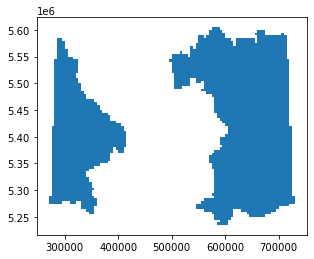

In [568]:
gdf.plot()

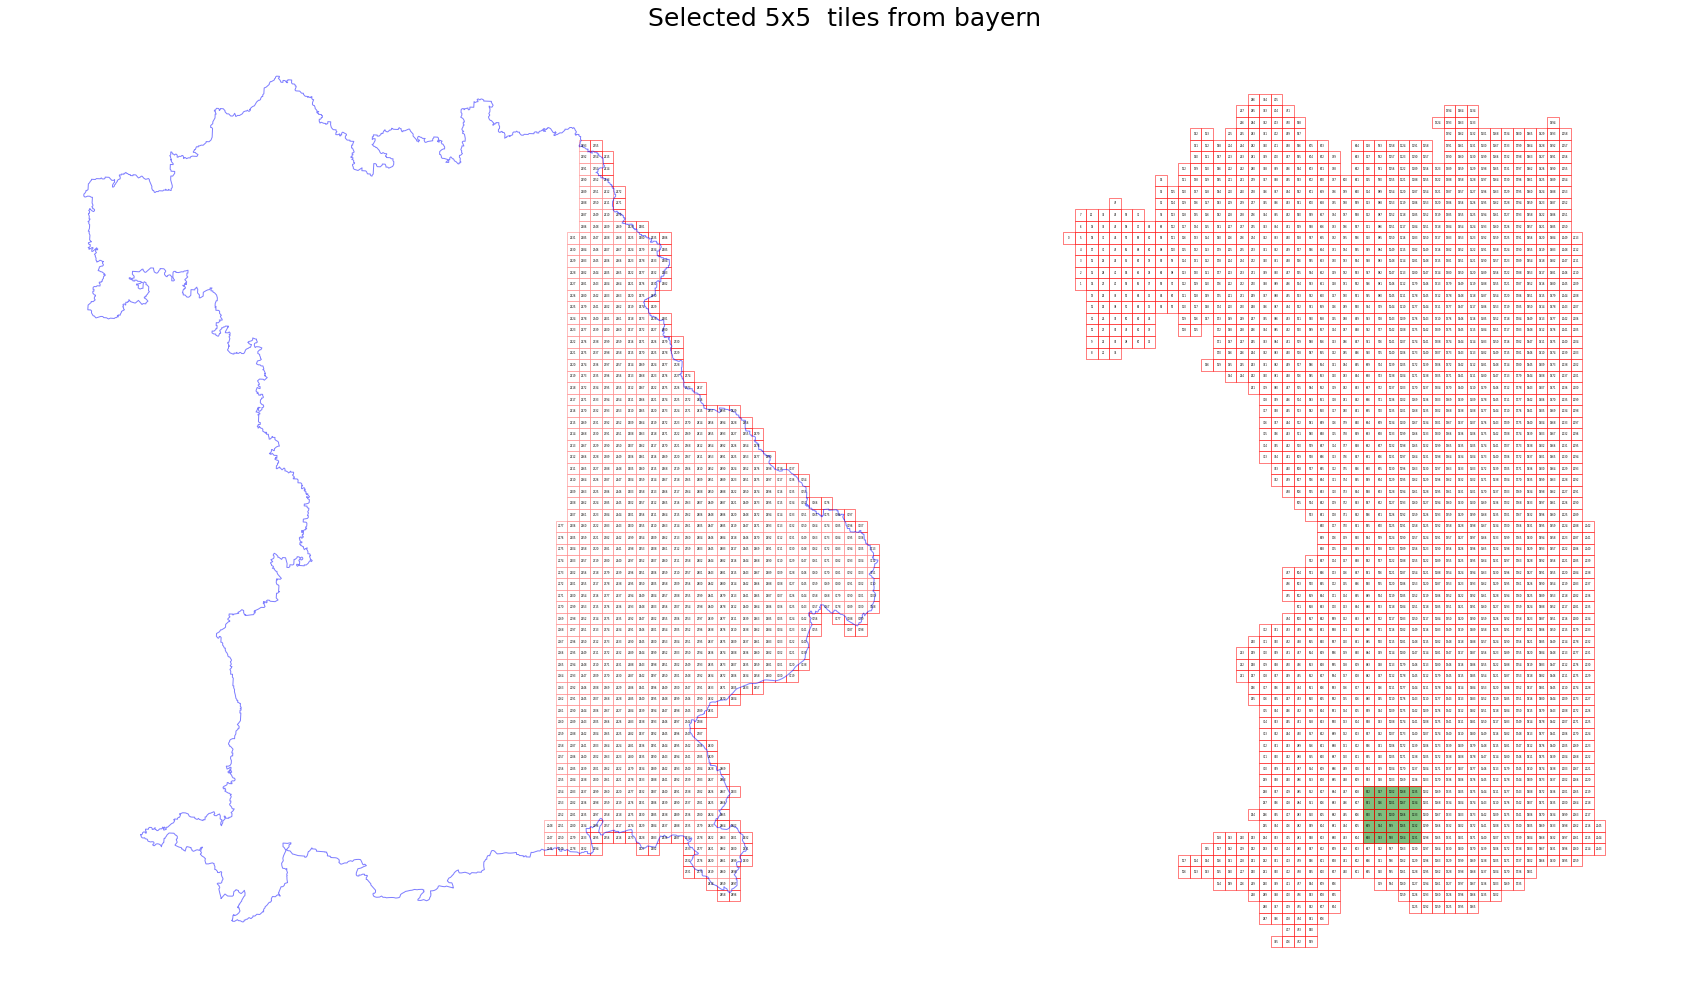

In [566]:
# figure
fig, ax = plt.subplots(figsize=(30, 30))
gdf.plot(ax=ax,facecolor='w',edgecolor='r',alpha=0.5)
bayern_crs.plot(ax=ax, facecolor='w',edgecolor='b',alpha=0.5)
ax.set_title('Selected 5x5  tiles from bayern', fontsize=25);
for bbox, info in zip(bbox_list, info_list):
    geo = bbox.geometry
    ax.text(geo.centroid.x, geo.centroid.y, info['index'], ha='center', va='center',fontsize=2.5)

gdf[gdf.index.isin(patchIDs)].plot(ax=ax,facecolor='g',edgecolor='r',alpha=0.5)

plt.axis('off');

In [570]:
FeatureType.DATA

<FeatureType.DATA: 'data'>

In [571]:
OverwritePermission.OVERWRITE_PATCH

<OverwritePermission.OVERWRITE_PATCH: 2>

In [572]:
SaveTask

eolearn.core.core_tasks.SaveTask

In [573]:
class LULC(MultiValueEnum):
    """ Enum class containing basic LULC types
    """
    NO_DATA            = 'No Data',            0,  '#ffffff'

In [575]:
a = LULC()

ValueError: 20 is not a valid LULC